In [1]:
from imports import *
import pickle

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cuda:0")

In [27]:
2048*6*10

122880

In [23]:

def get_encoder(model_name):
    if model_name == 'mobile_net':
        md = torchvision.models.mobilenet_v2(pretrained=True)
        encoder = nn.Sequential(*list(md.children())[:-1])
    elif model_name == 'resnet':
        md = torchvision.models.resnet50(pretrained=True)
        encoder = nn.Sequential(*list(md.children())[:-2])
    return encoder

class DecisionGenerator_no_attention(nn.Module):
    def __init__(self, encoder, encoder_dims, device, action_num=4, explanation_num=21):
        super().__init__()

        """
        encoder_dims = (F,H,W) 
            F:Feature shape (1280 for mobile net, 2048 for resnet)
            H,W = image feature height, width 
        """
        self.encoder = encoder

        assert len(encoder_dims) == 3, "encoder_dims has to be a triplet with shape (F,H,W)" 

        F,H,W = encoder_dims
        ind_dim = H*W*F
        self.action_branch = nn.Sequential(
                                nn.Linear(ind_dim,12),
                                nn.ReLU(),
                                # nn.Dropout(),
                                nn.Linear(12,action_num))

        self.explanation_branch = nn.Sequential(
                                nn.Linear(ind_dim,12),
                                nn.ReLU(),
                                # nn.Dropout(),
                                nn.Linear(12, explanation_num))

        self.action_loss_fn, self.reason_loss_fn = self.loss_fn(device)

    def loss_fn(self,device):
        class_weights = [1, 1, 2, 2]
        w = torch.FloatTensor(class_weights).to(device)
        action_loss = nn.BCEWithLogitsLoss(pos_weight=w).to(device)
        explanation_loss = nn.BCEWithLogitsLoss().to(device)
        return action_loss,explanation_loss


    def forward(self,images,targets=None):
        images = torch.stack(images)
        if self.training:
            assert targets is not None
            target_reasons = torch.stack([t['reason'] for t in targets])
            target_actions = torch.stack([t['action'] for t in targets])
        # print(images.shape)
        features = self.encoder(images) # 
        # print(features.shape)

        B,F,H,W = features.shape

        # print(features.view(B,F,H*W).transpose(1,2).shape)
        # print(transformed_feature.shape)
        feature_polled = torch.flatten(features,start_dim=1)

        # print(feature_polled.shape)

        actions = self.action_branch(feature_polled)
        reasons = self.explanation_branch(feature_polled)

        if self.training:
            action_loss = self.action_loss_fn(actions, target_actions)
            reason_loss = self.reason_loss_fn(reasons, target_reasons)
            loss_dic = {"action_loss":action_loss, "reason_loss":reason_loss}
            return loss_dic
        else:
            return {"action":torch.sigmoid(actions),"reasons":torch.sigmoid(reasons)}

encoder = get_encoder('resnet')

dg = DecisionGenerator_no_attention(encoder,encoder_dims=(2048,6,10), device='cpu' )
# params = sum([np.prod(p.size()) for p in model_parameters])
# print("len of params: ",params)

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(dg)

26457501

In [26]:
class MHSA2(nn.Module):
    def __init__(self,
            emb_dim,
            kqv_dim,
            output_dim=10,
            num_heads=8):
        super(MHSA2, self).__init__()
        self.emb_dim = emb_dim
        self.kqv_dim = kqv_dim
        self.num_heads = num_heads

        self.w_k = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
        self.w_q = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
        self.w_v = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
        self.w_out = nn.Linear(kqv_dim * num_heads, output_dim)

    def forward(self, x):

        b, t, _ = x.shape
        e = self.kqv_dim
        h = self.num_heads
        keys = self.w_k(x).view(b, t, h, e)
        values = self.w_v(x).view(b, t, h, e)
        queries = self.w_q(x).view(b, t, h, e)

        keys = keys.transpose(2, 1)
        queries = queries.transpose(2, 1)
        values = values.transpose(2, 1)

        dot = queries @ keys.transpose(3, 2)
        dot = dot / np.sqrt(e)
        dot = nn.functional.softmax(dot, dim=3)

        out = dot @ values
        out = out.transpose(1,2).contiguous().view(b, t, h * e)
        out = self.w_out(out)
        return out

class DecisionGenerator_whole_attention(nn.Module):
    def __init__(self, encoder, encoder_dims, device, num_heads=8, \
                 attention_out_dim=10, action_num=4, explanation_num=21):
        super().__init__()

        """
        encoder_dims = (F,H,W) 
            F:Feature shape (1280 for mobile net, 2048 for resnet)
            H,W = image feature height, width 
        """
        self.encoder = encoder

        assert len(encoder_dims) == 3, "encoder_dims has to be a triplet with shape (F,H,W)" 

        F,H,W = encoder_dims

        self.MHSA = MHSA2(emb_dim=F,kqv_dim=10,output_dim=attention_out_dim,num_heads=num_heads)

        T = H*W
        self.action_branch = nn.Sequential(
                                nn.Linear(attention_out_dim*T,64),
                                nn.ReLU(),
                                # nn.Dropout(),
                                nn.Linear(64,action_num))

        self.explanation_branch = nn.Sequential(
                                nn.Linear(attention_out_dim*T,64),
                                nn.ReLU(),
                                # nn.Dropout(),
                                nn.Linear(64, explanation_num))

        self.action_loss_fn, self.reason_loss_fn = self.loss_fn(device)

    def loss_fn(self,device):
        class_weights = [1, 1, 2, 2]
        w = torch.FloatTensor(class_weights).to(device)
        action_loss = nn.BCEWithLogitsLoss(pos_weight=w).to(device)
        explanation_loss = nn.BCEWithLogitsLoss().to(device)
        return action_loss,explanation_loss


    def forward(self,images,targets=None):
        images = torch.stack(images)
        if self.training:
            assert targets is not None
            target_reasons = torch.stack([t['reason'] for t in targets])
            target_actions = torch.stack([t['action'] for t in targets])
        # print(images.shape)
        features = self.encoder(images) # 
        # print(features.shape)

        B,F,H,W = features.shape

        # print(features.view(B,F,H*W).transpose(1,2).shape)
        
        transformed_feature = self.MHSA(features.view(B,F,H*W).transpose(1,2)) #(B, H, T, 10)
        # print(transformed_feature.shape)
        feature_polled = torch.flatten(transformed_feature,start_dim=1)

        # print(feature_polled.shape)

        actions = self.action_branch(feature_polled)
        reasons = self.explanation_branch(feature_polled)

        if self.training:
            action_loss = self.action_loss_fn(actions, target_actions)
            reason_loss = self.reason_loss_fn(reasons, target_reasons)
            loss_dic = {"action_loss":action_loss, "reason_loss":reason_loss}
            return loss_dic
        else:
            return {"action":torch.sigmoid(actions),"reasons":torch.sigmoid(reasons)}

dga = DecisionGenerator_whole_attention(encoder, encoder_dims=(2048,6,10), device='cpu')
count_parameters(dga)


24078915

In [ ]:
24078915

In [2]:
classes = {
    "bus": 0,
    "traffic light": 1,
    "traffic sign": 2,
    "person": 3,
    "bike": 4,
    "truck": 5,
    "motor": 6,
    "car": 7,
    "train": 8,
    "rider": 9,
}

class_2_name = dict([(value, key) for key, value in classes.items()])
num_classes = len(classes)

## 1. Load model

In [3]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,num_classes)
    return model.cpu()

In [4]:
model = get_model(num_classes)

In [5]:
checkpoint = torch.load('saved_models/bdd100k_24.pth')
model.load_state_dict(checkpoint['model'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

## 2. Show sample plot

In [6]:
def get_preds(idx,img_datalist,threshold):
    im0 = Image.open(img_datalist[idx])
    im0_tensor = torchvision.transforms.ToTensor()(im0)
    pred = model([im0_tensor])
    total_preds = []
    for n,confidence in enumerate(pred[0]['scores']):
        if confidence>threshold:
            pred_update = {}
            pred_update['boxes'] = pred[0]['boxes'][n]
            pred_update['labels'] = pred[0]['labels'][n]
            pred_update['scores'] = pred[0]['scores'][n]
        total_preds.append(pred_update)
    return im0,total_preds

In [7]:
def plot_from_image_preds(img,total_preds):
    fig,ax = plt.subplots(1,figsize=(20,10))
    for i in range(len(total_preds)):
        xy = total_preds[i]['boxes'][0],total_preds[i]['boxes'][1]
        width = total_preds[i]['boxes'][2]-total_preds[i]['boxes'][0]
        height = total_preds[i]['boxes'][3]-total_preds[i]['boxes'][1]
        rect = patches.Rectangle(xy,width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.text(xy[0],xy[1],class_2_name[total_preds[i]['labels'].item()])
        ax.add_patch(rect)
    ax.imshow(img)

In [8]:
with open("datalists/bdd100k_val_images_path.txt", "rb") as fp:
    val_img_paths = pickle.load(fp)

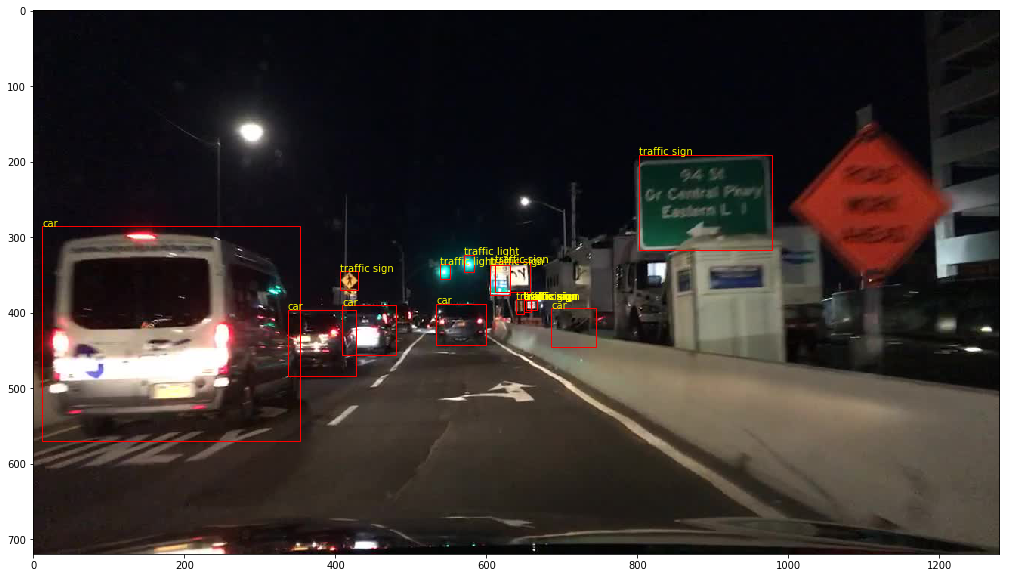

In [9]:
im, total_preds = get_preds(751,val_img_paths,0.6)
plot_from_image_preds(im,total_preds)

## 3. Test

In [10]:
im0 = Image.open(val_img_paths[100])
im0_tensor = torchvision.transforms.ToTensor()(im0)

In [11]:
model.backbone.out_channels

256

In [12]:
images, targets = model.transform([im0_tensor,im0_tensor])

In [13]:
images.tensors.shape

torch.Size([2, 3, 768, 1344])

In [14]:
features = model.backbone(images.tensors)

In [15]:
proposals, _ = model.rpn(images, features, targets)

In [16]:
box_features1 = model.roi_heads.box_roi_pool(features,proposals,images.image_sizes)
box_features2 = model.roi_heads.box_head(box_features1)


class_logits, box_regression = model.roi_heads.box_predictor(box_features2)


## Test Multihead attention in pytorch

In [17]:
box_features2 = box_features2.view(2,1000,1024)
box_features2.shape

torch.Size([2, 1000, 1024])

In [20]:
class MHSA(nn.Module):
  def __init__(self,
         emb_dim,
         kqv_dim,
         num_heads=1):
    super(MHSA, self).__init__()
    self.emb_dim = emb_dim
    self.kqv_dim = kqv_dim
    self.num_heads = num_heads

    self.w_k = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
    self.w_q = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
    self.w_v = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
    self.w_out = nn.Linear(kqv_dim * num_heads, emb_dim)

  def forward(self, x):

    b, t, _ = x.shape
    e = self.kqv_dim
    h = self.num_heads
    keys = self.w_k(x).view(b, t, h, e)
    values = self.w_v(x).view(b, t, h, e)
    queries = self.w_q(x).view(b, t, h, e)

    keys = keys.transpose(2, 1)
    print("keys",keys.shape)
    queries = queries.transpose(2, 1) # b, h, t, e
    print("queries",queries.shape)
    values = values.transpose(2, 1)  # b, h, t, e
    print("values",values.shape)
    dot = queries @ keys.transpose(3, 2)
    dot = dot / np.sqrt(e)
    print("dot",dot.shape)
    weights = nn.functional.softmax(dot, dim=3)

    print(values.shape)
    out = weights @ values
    print(out.shape)
    out = out.transpose(1,2).contiguous().view(b, t, h * e)
    out = self.w_out(out)
    return out, weights

attention = MHSA(1024,10,num_heads=8)

val, score = attention(box_features2)

keys torch.Size([2, 8, 1000, 10])
queries torch.Size([2, 8, 1000, 10])
values torch.Size([2, 8, 1000, 10])
dot torch.Size([2, 8, 1000, 1000])
torch.Size([2, 8, 1000, 10])
torch.Size([2, 8, 1000, 10])


In [21]:
score.shape

torch.Size([2, 8, 1000, 1000])

In [108]:
attention.parameters

<bound method Module.parameters of MHSA(
  (w_k): Linear(in_features=1024, out_features=80, bias=False)
  (w_q): Linear(in_features=1024, out_features=80, bias=False)
  (w_v): Linear(in_features=1024, out_features=80, bias=False)
  (w_out): Linear(in_features=80, out_features=1024, bias=True)
)>

In [104]:
model_parameters = filter(lambda p: p.requires_grad, attention.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [110]:
1024*4*80+1024

328704

In [ ]:
nn.Linear()

In [ ]:
nn.MultiheadAttention()

## Test hard attention

In [18]:
box_features2.shape

torch.Size([2000, 1024])

In [20]:
box_features2 = box_features2.view(2,1000,1024)

In [21]:
box_features2.shape

torch.Size([2, 1000, 1024])

In [34]:
attention = nn.Sequential(nn.Linear(1024,1),nn.Softmax(dim=1))

In [35]:
attention(box_features2)

tensor([[[0.0010],
         [0.0010],
         [0.0010],
         ...,
         [0.0009],
         [0.0009],
         [0.0009]],

        [[0.0010],
         [0.0010],
         [0.0010],
         ...,
         [0.0009],
         [0.0009],
         [0.0009]]], grad_fn=<SoftmaxBackward>)

In [44]:
score = attention(box_features2)

In [46]:
score.shape

torch.Size([2, 1000, 1])

In [59]:
box_features2.shape

torch.Size([2, 1000, 1024])

In [48]:
_,ind = torch.topk(score,k=10,dim=1)

In [58]:
torch.index_select(box_features2,)

IndexError: index 499 is out of bounds for dimension 0 with size 2

In [75]:
ind

tensor([[[343],
         [399],
         [433],
         [287],
         [374],
         [499],
         [504],
         [496],
         [486],
         [231]],

        [[343],
         [399],
         [433],
         [287],
         [374],
         [499],
         [504],
         [496],
         [486],
         [231]]])

In [73]:
torch.gather(box_features2,1,ind.expand(ind.size(0),ind.size(1),box_features2.size(2)))

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.8045, 0.2506],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7870, 0.2670],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7796, 0.2517],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.8663, 0.2494],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.8347, 0.2430],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5071, 0.2162]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.8045, 0.2506],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7870, 0.2670],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7796, 0.2517],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.8663, 0.2494],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.8347, 0.2430],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5071, 0.2162]]],
       grad_fn=<GatherBackward>)

In [78]:
box_features2[1,399,:]

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7870, 0.2670],
       grad_fn=<SliceBackward>)

In [64]:
box_features2[ind,:]

IndexError: index 504 is out of bounds for dimension 0 with size 2

In [42]:
(box_features2*attention(box_features2)).shape

torch.Size([2, 1000, 1024])

In [57]:
ind.squeeze(-1).shape

torch.Size([2, 10])

In [31]:
proposals[0].shape

torch.Size([1000, 4])

In [24]:
 boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, images.image_sizes)

In [27]:
len(boxes)

2

In [156]:
box_features2_reshaped = box_features2.view(2,1000,1024)



In [169]:
box_features2_reshaped.shape,box_features1.shape

(torch.Size([2, 1000, 1024]), torch.Size([2000, 256, 7, 7]))

In [151]:
detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes)

In [153]:
detections[0]['boxes'].shape

torch.Size([96, 4])

In [167]:
class MHSA(nn.Module):
  def __init__(self,
         emb_dim,
         kqv_dim,
         num_heads=1):
    super(MHSA, self).__init__()
    self.emb_dim = emb_dim
    self.kqv_dim = kqv_dim
    self.num_heads = num_heads

    self.w_k = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
    self.w_q = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
    self.w_v = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
    self.w_out = nn.Linear(kqv_dim * num_heads, emb_dim)

  def forward(self, x):

    b, t, _ = x.shape
    e = self.kqv_dim
    h = self.num_heads
    keys = self.w_k(x).view(b, t, h, e)
    values = self.w_v(x).view(b, t, h, e)
    queries = self.w_q(x).view(b, t, h, e)

    keys = keys.transpose(2, 1)
    queries = queries.transpose(2, 1)
    values = values.transpose(2, 1)

    dot = queries @ keys.transpose(3, 2)
    dot = dot / np.sqrt(e)
    dot = nn.functional.softmax(dot, dim=3)

    out = dot @ values
    out = out.transpose(1,2).contiguous().view(b, t, h * e)
    out = self.w_out(out)
    return out

attention = MHSA(1024,10,num_heads=8)

In [170]:
attention_result = attention(box_features2_reshaped)
attention_result.shape

torch.Size([2, 1000, 1024])

In [180]:
torch.max(attention_result,1)[0]

tensor([[-0.0391,  0.1408, -0.1613,  ..., -0.1101,  0.0225,  0.1068],
        [-0.0391,  0.1408, -0.1613,  ..., -0.1101,  0.0225,  0.1068]],
       grad_fn=<MaxBackward0>)

In [181]:
class DecisionGenerator(nn.Module):
    def __init__(self,faster_rcnn_model,batch_size=2,action_num=4,explanation_num=21,freeze_rcnn=True):
        super().__init__()

        self.rcnn = faster_rcnn_model
        self.batch_size = batch_size

        if freeze_rcnn:
            self.rcnn.params.requires_grad = False
        self.object_attention = MHSA(1024, kqv_dim=10, num_heads=8)
        self.action_branch = nn.Linear(1024,action_num)
        self.explanation_branch = nn.Linear(1024, explanation_num)

    def forward(images):

        images,_ = rcnn.transform(images)
        features = rcnn.backbone(images.tensors)
        proposals, _ = rcnn.rpn(images, features)

        box_features = rcnn.roi_heads.box_roi_pool(features,proposals,images.image_sizes)
        box_features = rcnn.roi_heads.box_head(box_features).view(self.batch_size, -1, 1024)  #(B, num_proposal, 1024)
        
        box_features = self.object_attention(box_features) #(B, num_proposal, 1024)
        feature_polled,_ = torch.max(box_features,1)

        actions = self.action_branch(feature_polled)
        explanations = self.explanation_branch(feature_polled)

        return actions,explanations


In [ ]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention